In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
%matplotlib inline
pd.options.display.max_rows = 10
pd.options.display.max_columns = 10

In [3]:
df = pd.read_csv('Castalia-Trace.txt', header=None, sep='\t', names=['time', 'entity', 'event'])

# mark experiment number
reps = 0
df['reps'] = 0
for idx, row in df.iterrows():
    if pd.notnull(row.event) and 'sending' in row.event:
        reps += 1
    df.set_value(idx, 'reps', reps)

df

,time,entity,event,reps
0,0.027540,SN.node[0].Application,Not sending packets,1
1,899.953299,SN.node[16].Application,Sending packet #0,1
2,899.964665,SN.node[31].Application,Sending packet #0,1
3,899.966994,SN.node[11].Application,Sending packet #0,1
4,899.972774,SN.node[41].Application,Sending packet #0,1
...,...,...,...,...
7915,14399.983329,SN.node[0].Application,Received packet #15 from node 47,5
7916,14399.989842,SN.node[39].Application,Sending packet #15,5
7917,14399.991008,SN.node[0].Application,Received packet #15 from node 26,5
7918,14399.998689,SN.node[0].Application,Received packet #15 from node 39,5


In [4]:
sending = df[df.event.str.contains('Sending')]
sending['from_node'] = sending.entity.apply(lambda x: int(re.search(r"\[([0-9]+)\]", x).group(1)))
sending['sequence_number'] = sending.event.apply(lambda x: int(re.search(r"#([0-9]+)", x).group(1)))
del sending['entity'], sending['event']
sending

/home/m/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/m/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,time,reps,from_node,sequence_number
1,899.953299,1,16,0
2,899.964665,1,31,0
3,899.966994,1,11,0
4,899.972774,1,41,0
5,899.975449,1,43,0
...,...,...,...,...
7909,14399.949765,5,26,15
7910,14399.952797,5,18,15
7913,14399.969758,5,47,15
7916,14399.989842,5,39,15


In [5]:
receiving = df[df.event.str.contains('Received packet')]
receiving['from_node'] = receiving.event.apply(lambda x: int(re.search(r"node ([0-9]+)", x).group(1)))
receiving['sequence_number'] = receiving.event.apply(lambda x: int(re.search(r"#([0-9]+)", x).group(1)))
del receiving['entity'], receiving['event']
receiving

/home/m/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/m/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,time,reps,from_node,sequence_number
6,899.976757,1,16,0
16,899.994676,1,11,0
51,900.063806,1,13,0
53,900.075325,1,8,0
56,900.086846,1,17,0
...,...,...,...,...
7912,14399.962848,5,36,15
7914,14399.973089,5,18,15
7915,14399.983329,5,47,15
7917,14399.991008,5,26,15


In [6]:
merged = pd.merge(sending, receiving, on=['from_node', 'sequence_number', 'reps'], 
                  suffixes=('_sent', '_received'), how='left')
merged

,time_sent,reps,from_node,sequence_number,time_received
0,899.953299,1,16,0,899.976757
1,899.964665,1,31,0,900.310860
2,899.966994,1,11,0,899.994676
3,899.972774,1,41,0,900.126526
4,899.975449,1,43,0,900.223811
...,...,...,...,...,...
3974,14399.949765,5,26,15,14399.991008
3975,14399.952797,5,18,15,14399.973089
3976,14399.969758,5,47,15,14399.983329
3977,14399.989842,5,39,15,14399.998689


In [7]:
merged[merged.time_received.isnull()].from_node.value_counts()

15    1
14    1
13    1
10    1
25    1
     ..
20    1
3     1
34    1
33    1
51    1
Name: from_node, dtype: int64

In [8]:
latencies = merged.groupby(['from_node', 'reps'])\
                .apply(lambda x: (x.time_received - x.time_sent).quantile(.95) * 1000).unstack()
latencies

reps,1,2,3,4,5
from_node,,,,,
1,322.580477,232.798433,408.194241,354.675757,248.089680
2,208.698167,254.540442,463.681371,221.585510,306.500923
3,401.462408,326.038964,715.201134,332.761367,184.099377
4,272.688455,189.211365,275.449533,420.573817,382.113655
5,344.828296,275.694142,494.005722,276.972668,186.003228
...,...,...,...,...,...
47,372.843028,366.246247,459.009685,266.917022,382.330860
48,308.174524,201.914718,332.567447,252.093565,350.447551
49,265.781108,329.899739,302.094268,215.407207,252.773481


In [9]:
# TODO: max latency

In [10]:
latencies.describe()

reps,1,2,3,4,5
count,51.000000,51.000000,51.000000,51.000000,51.000000
mean,259.713741,294.597178,343.654018,291.032167,305.393110
std,87.865540,100.770300,130.162118,99.627124,89.685631
min,94.301400,97.024402,67.752305,75.181111,108.614323
25%,184.403279,226.680500,276.152084,221.593980,250.431581
50%,265.781108,286.636749,349.648610,302.066928,300.051142
75%,333.262718,364.083822,422.723420,359.892169,380.842459
max,440.976880,524.235977,715.201134,479.927612,507.930033


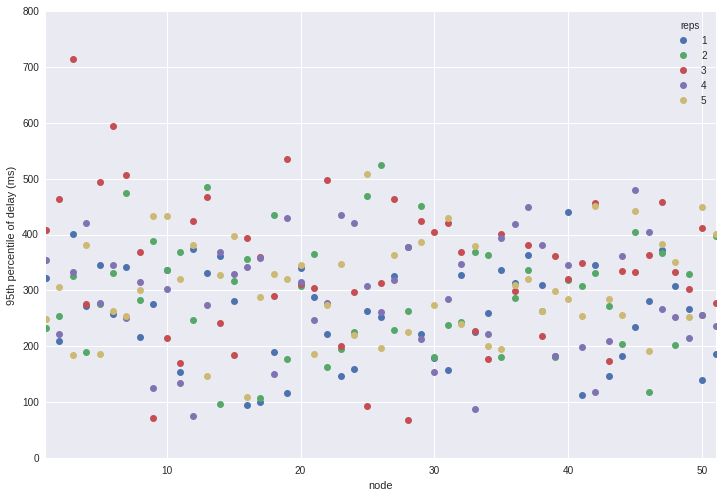

In [11]:
ax = latencies.plot(style='o', figsize=(12, 8))
ax.set_xlabel('node')
ax.set_ylabel('95th percentile of delay (ms)')
#ax.set_ylim((0, 200))